<a href="https://colab.research.google.com/github/TNK443/RecPadroes/blob/main/04_ArvoreDeDecisao_Tarefa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Heurística para escolher o melhor valor de cada característica**

Crie a sua heurística para escolher a melhor característica para um nó de uma árvore de decisão e compare com a implementação feita nos vídeos postados nesse tópico aqui no AVA e com a implementação do scikit learn.

Faça comparações plotando as regiões de decisão com resubstituição para a base iris e as características usadas nos vídeos.

Também faça comparações usando validação cruzada com pelo menos 3 bases de classificação com atributos contínuos.

Escreva um parágrafo expondo sua interpretação dos resultados obtidos.

### Bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics

from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter

### Carregando a Base IRIS

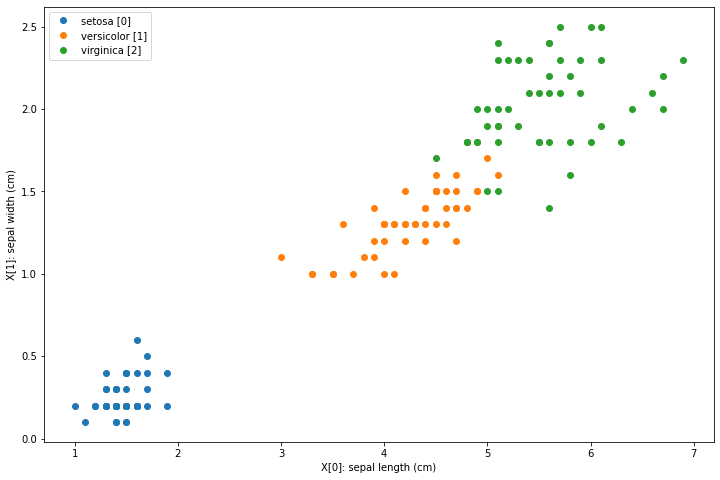

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris.data[:,2:], iris.target

plt.figure(figsize=(12,8))
for k in sorted(set(y)):
    plt.plot(X[:, 0][y==k], X[:, 1][y==k], 'o', 
             label=f"{iris.target_names[k]} [{k}]")


plt.legend()
plt.xlabel(f"X[0]: {iris.feature_names[0]}")
plt.ylabel(f"X[1]: {iris.feature_names[1]}")
plt.show()

### IMPUREZA

In [3]:
def impureza(y): #Gini
    labels = list(set(y))                       # lista com labels únicos do y
    labels.sort()                               # ordernar dá uma garantia de que a lista sempre vai estar na mesma sequência.
    probabilidades = np.zeros((len(labels),))   # probabilidade de cada caracteristica/label de estar mais puro que os demais.
    for i,k in enumerate(labels):               # passa por todos os labels
        probabilidades[i] = sum(y==k)/len(y)    # A probabilidade de Label ocorrer.
    result = 1 - sum(probabilidades**2)         # A Gini eleva essa probabilidade ao quadrado.
    return result


ytmp = y[:]
valor = impureza(ytmp)
print("Impureza_GINI(y)=", valor)

Impureza_GINI(y)= 0.6666666666666667


In [4]:
def impurezaValor(x, y, valor):
    # MAIORES que o valor
    maiores = x > valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    # MENORES que o valor
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)

    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores

    return impurezaTotal, impurezaMaiores, impurezaMenores

# Impureza de uma Valor determinado
# impurezaValor(X[:,0], y, 2)
print("Impureza(Maior|Menor) do Valor '2' =", impurezaValor(X[:,0],y,2)[0])

Impureza(Maior|Menor) do Valor '2' = 0.3333333333333333


In [5]:
def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

In [6]:
# ----------------------------------------------------------------------------------------------------

## Crie a sua heurística para escolher a melhor característica para um nó de uma árvore de decisão e compare com a implementação feita nos vídeos postados nesse tópico aqui no AVA e com a implementação do scikit learn.

### Heurística Padrão dado em aula.

In [7]:
def melhorValor_HPadrao(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)

    while True:
        valor = (xmax+xmin)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza


melhorValor_HPadrao(X[:,0], y)

(2.475, 0.3333333333333333)

In [8]:
def melhorCaracteristica_HPadrao(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor_HPadrao(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)    
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)

    return caracteristica, valores[caracteristica], impurezas[caracteristica]

print(melhorCaracteristica_HPadrao(X,y))

(0, 2.475, 0.3333333333333333)


In [9]:
class Arvore_A(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica_HPadrao(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore_A()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore_A()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores]  = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])

        return y

modelo_A = Arvore_A()
modelo_A.fit(X,y)
ypred_A = modelo_A.predict(X)
accuracy_score(y, ypred_A), (ypred_A == y)

(0.9933333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

### Heurística Criada porém não houve melhoras.

In [10]:
def melhorValor_HPior(x, y):
    result = None
    menorImpureza = float('inf')

    while True:
        valor = np.median(x)
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza


melhorValor_HPior(X[:,0], y)

(4.35, 0.4444444444444444)

In [11]:
def melhorCaracteristica_HPior(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor_HPior(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)    
    
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)

    return caracteristica, valores[caracteristica], impurezas[caracteristica]

print(melhorCaracteristica_HPior(X,y))

(1, 1.3, 0.44301994301994296)


In [12]:
class Arvore_B(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica_HPior(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore_B()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore_B()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores]  = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])

        return y

modelo_B = Arvore_B()
modelo_B.fit(X,y)
ypred_B = modelo_B.predict(X)
accuracy_score(y, ypred_B), (ypred_B == y)

(0.9933333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

### Heurística Criada com um pequeno ajuste, afetando um pouca a melhora do np.mean(scores['test_score'].

In [13]:
def melhorValor_HBestScore(x, y):
    result = None
    menorImpureza = float('inf')

    while True:
        xmax = np.max(x)
        xmin = np.min(x)
        valor = (xmax+xmin)/2

        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza


melhorValor_HBestScore(X[:,0], y)

(3.95, 0.41235341069564685)

In [14]:
def melhorCaracteristica_HBestScore(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor_HBestScore(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)    
    
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)

    return caracteristica, valores[caracteristica], impurezas[caracteristica]

print(melhorCaracteristica_HBestScore(X,y))

(0, 3.95, 0.41235341069564685)


In [15]:
class Arvore_C(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica_HBestScore(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore_C()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore_C()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores]  = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])

        return y

modelo_C = Arvore_C()
modelo_C.fit(X,y)
ypred_C = modelo_C.predict(X)
accuracy_score(y, ypred_C), (ypred_C == y)

(0.9933333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

### Outra Heurística

In [16]:
def melhorValor_Z(x, y):
    result = None
    menorImpureza = float('inf')

    zSort = np.sort(x)
    z20P = int(len(x)*0.2)
    z20PINI = sum(zSort[:z20P])
    z20PEND = sum(zSort[(len(x)-z20P):])

    if (z20PINI == 0):
        z20PMin = 0
    else: 
        z20PMin = (z20PINI/z20P)
    
    if (z20PEND == 0):
        z20PMax = 0
    else:
        z20PMax = (z20PEND/z20P)


    while True:
        valor = (z20PMin+z20PMax)/2

        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza


melhorValor_Z(X[:,0], y)

(3.6316666666666664, 0.383485309017224)

In [17]:
def melhorCaracteristica_Z(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor_Z(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)    
    
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)

    return caracteristica, valores[caracteristica], impurezas[caracteristica]

print(melhorCaracteristica_Z(X,y))

(0, 3.6316666666666664, 0.383485309017224)


In [18]:
class Arvore_Z(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica_Z(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore_Z()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore_Z()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores]  = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])

        return y

modelo_Z = Arvore_Z()
modelo_Z.fit(X,y)
ypred_Z = modelo_Z.predict(X)
accuracy_score(y, ypred_Z), (ypred_Z == y)

(0.9733333333333334,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,

In [19]:
# ----------------------------------------------------------------------------------------------------

## Faça comparações plotando as regiões de decisão com resubstituição para a base iris e as características usadas nos vídeos.

In [20]:
def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)

    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]

    ypred = modelo.predict(Xdec)

    plt.figure(figsize=(12,8))
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o')

    plt.xlabel("X[0]")
    plt.ylabel("X[1]")
    plt.show()

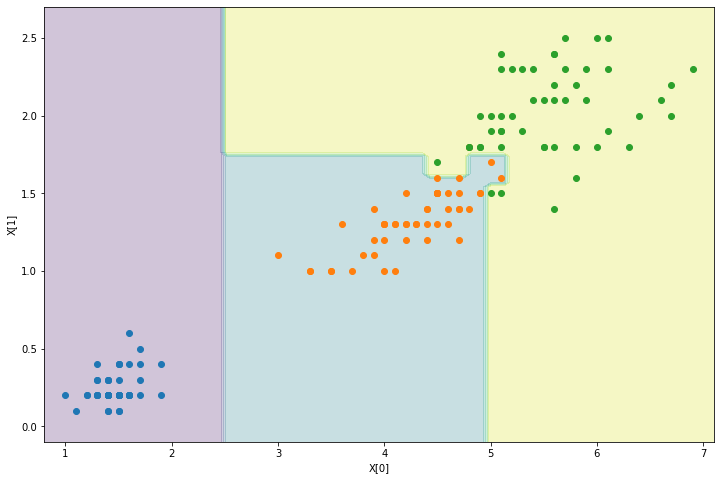

In [21]:
plotDecisao(Arvore_A(), X, y)

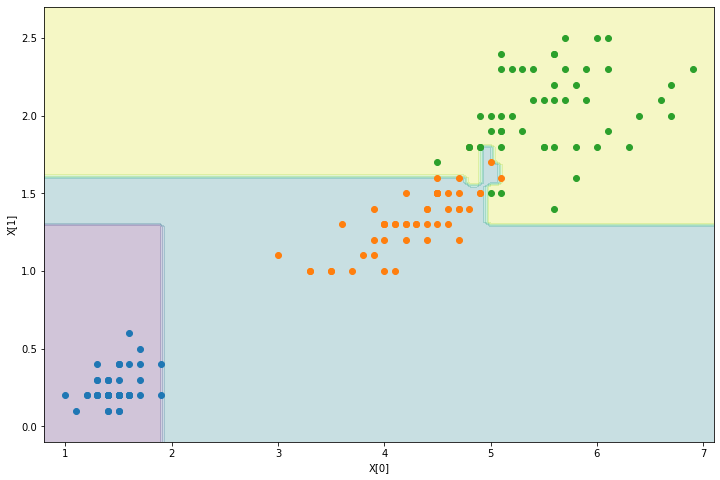

In [22]:
plotDecisao(Arvore_B(), X, y)

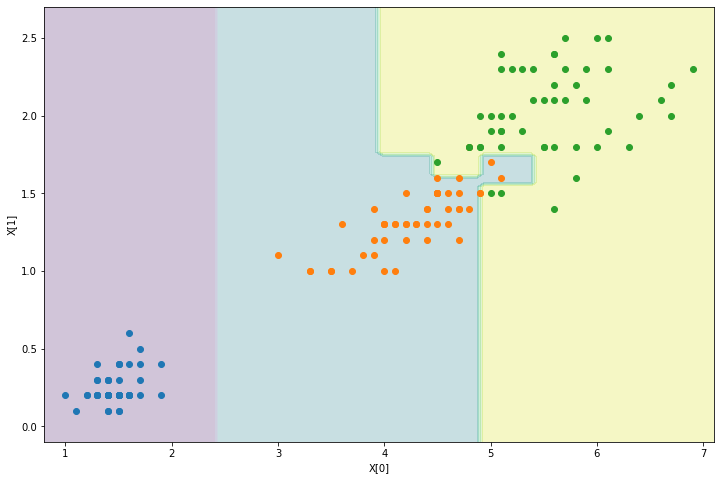

In [23]:
plotDecisao(Arvore_C(), X, y)

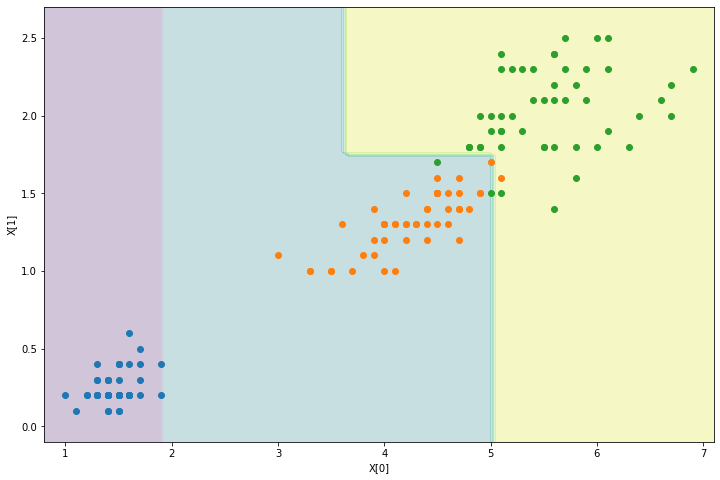

In [24]:
plotDecisao(Arvore_Z(), X, y)

In [25]:
from sklearn.model_selection import cross_validate

scores = cross_validate(Arvore_A(), X, y)

print("Scores:", scores['test_score'])
print("Mean:",np.mean(scores['test_score']))

Scores: [0.96666667 0.96666667 0.9        0.93333333 1.        ]
Mean: 0.9533333333333334


In [26]:
scores = cross_validate(Arvore_B(), X, y)

print("Scores:", scores['test_score'])
print("Mean:",np.mean(scores['test_score']))

Scores: [0.96666667 0.96666667 0.83333333 0.9        1.        ]
Mean: 0.9333333333333332


In [27]:
scores = cross_validate(Arvore_C(), X, y)

print("Scores:", scores['test_score'])
print("Mean:",np.mean(scores['test_score']))

Scores: [0.96666667 0.96666667 0.93333333 0.93333333 1.        ]
Mean: 0.96


In [28]:
scores = cross_validate(Arvore_Z(), X, y)

print("Scores:", scores['test_score'])
print("Mean:",np.mean(scores['test_score']))

Scores: [0.96666667 0.96666667 0.9        0.9        1.        ]
Mean: 0.9466666666666667


In [29]:
# ----------------------------------------------------------------------------------------------------

## Também faça comparações usando validação cruzada com pelo menos 3 bases de classificação com atributos contínuos.

### BASE01 (sklearn.datasets.load_wine)

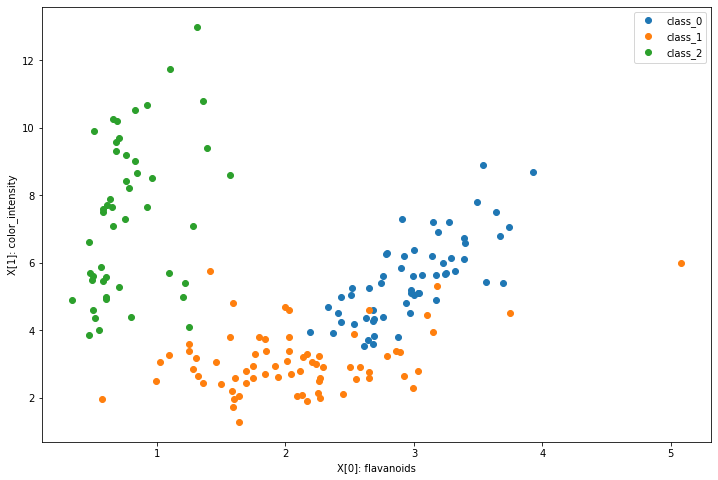

In [30]:
from sklearn.datasets import load_wine

dataset1 = load_wine()
X1, y1 = dataset1.data[:,[6,9]], dataset1.target

plt.figure(figsize=(12,8))
for k in sorted(set(y1)):
    plt.plot(X1[:,0][y1==k], X1[:,1][y1==k], "o", label=f"{dataset1.target_names[k]}")

plt.legend()
plt.xlabel(f"X[0]: {dataset1.feature_names[6]}")
plt.ylabel(f"X[1]: {dataset1.feature_names[9]}")

plt.show()

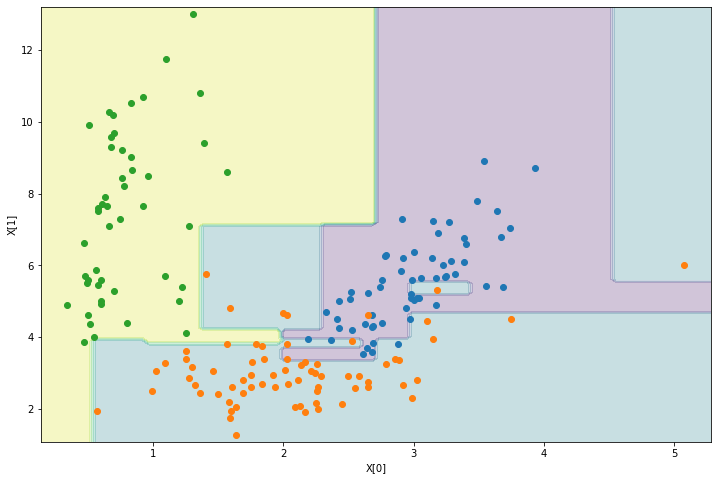

In [31]:
plotDecisao(Arvore_A(), X1, y1)

In [32]:
scores = cross_validate(Arvore_A(), X1, y1)

print("Scores:", scores['test_score'])
print("Mean:",np.mean(scores['test_score']))

Scores: [0.86111111 0.94444444 0.86111111 0.88571429 0.97142857]
Mean: 0.9047619047619048


### BASE 02 (sklearn.datasets.load_breast_cancer)

In [ ]:
from sklearn.datasets import load_breast_cancer

dataset2 = load_breast_cancer()
print(dataset2.DESCR)

No handles with labels found to put in legend.


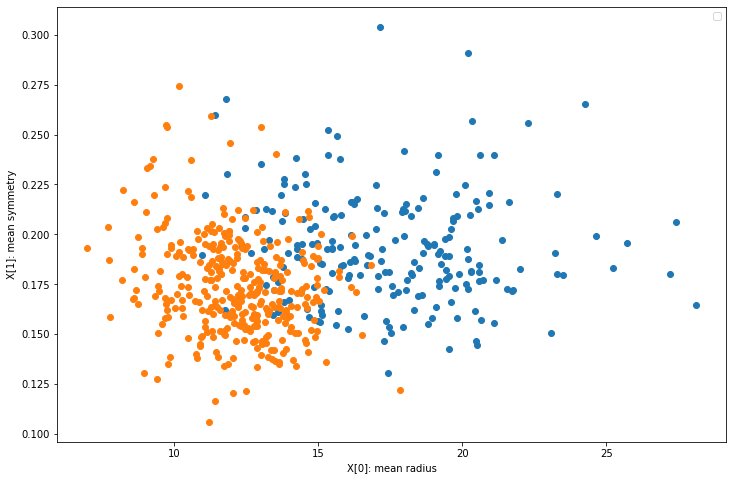

In [34]:
X2, y2 = dataset2.data[:,[0,8]], dataset2.target

plt.figure(figsize=(12,8))
for k in sorted(set(y2)):
    plt.plot(X2[:, 0][y2==k], X2[:, 1][y2==k], 'o')


plt.legend()
plt.xlabel(f"X[0]: {dataset2.feature_names[0]}")
plt.ylabel(f"X[1]: {dataset2.feature_names[8]}")
plt.show()

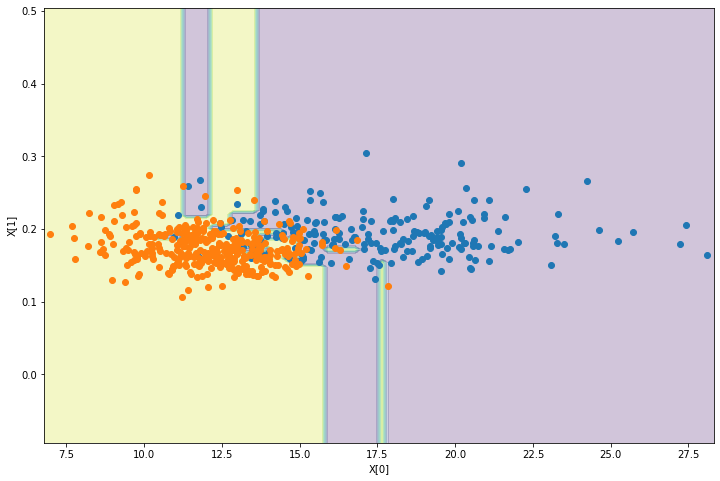

In [35]:
plotDecisao(Arvore_Z(), X2, y2)

In [36]:
scores = cross_validate(Arvore_Z(), X2, y2)

print("Scores:", scores['test_score'])
print("Mean:",np.mean(scores['test_score']))

Scores: [0.86842105 0.84210526 0.89473684 0.89473684 0.86725664]
Mean: 0.8734513274336283


### BASE03 (sklearn.datasets.fetch_openml - WDBC)

No handles with labels found to put in legend.


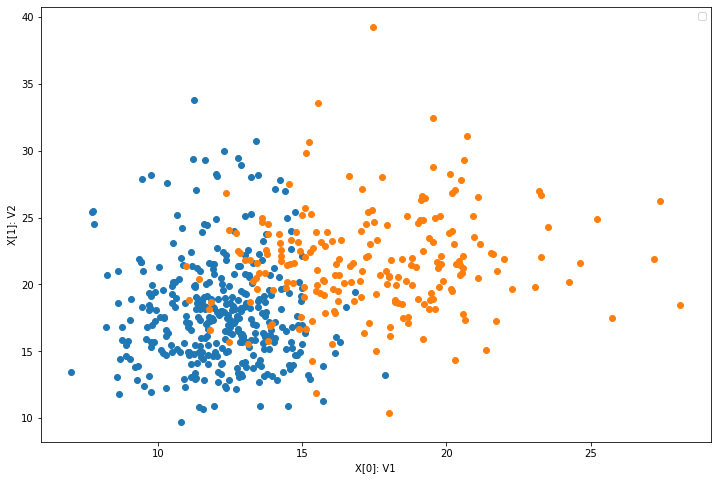

In [37]:
from sklearn.datasets import fetch_openml

# https://www.openml.org/d/1510
#
# Breast Cancer Wisconsin (Diagnostic) Data Set (WDBC). Features are computed from a digitized 
# image of a fine needle aspirate (FNA) of a breast mass.
# They describe characteristics of the cell nuclei present in the image.
# The target feature records the prognosis (benign (1) or malignant (2)).

dataset3 = fetch_openml('wdbc')
X3, y3 = dataset3.data[:,:2], np.array(dataset3.target).astype(np.int)

plt.figure(figsize=(12,8))
for k in sorted(set(y3)):
    plt.plot(X3[:, 0][y3==k], X3[:, 1][y3==k], 'o')


plt.legend()
plt.xlabel(f"X[0]: {dataset3.feature_names[0]}")
plt.ylabel(f"X[1]: {dataset3.feature_names[1]}")
plt.show()

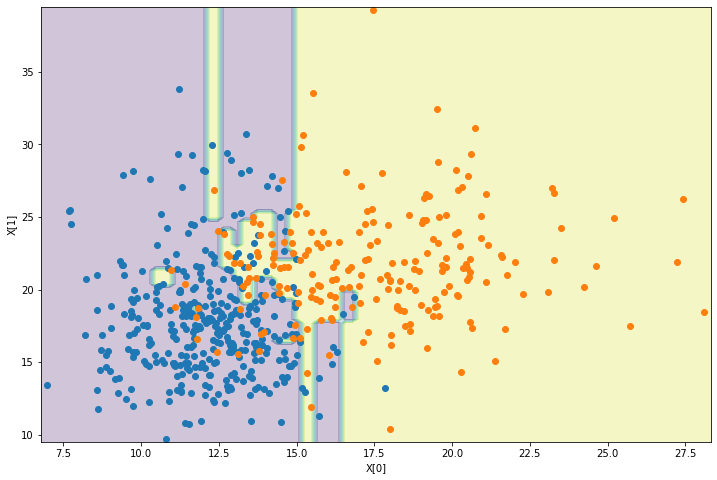

In [38]:
plotDecisao(Arvore_Z(), X3, y3)

In [39]:
scores = cross_validate(Arvore_Z(), X3, y3)

print("Scores:", scores['test_score'])
print("Mean:",np.mean(scores['test_score']))

Scores: [0.8245614  0.81578947 0.87719298 0.88596491 0.85840708]
Mean: 0.8523831703151684


In [40]:
# ----------------------------------------------------------------------------------------------------

## Escreva um parágrafo expondo sua interpretação dos resultados obtidos.

Foram criadas 4 Heurísticas distintas.
Sendo que para alguns exemplos a Heurística demonstrada em aula teve um resultado médio melhor, pois ele praticamente conseguia boas pontuações em todas as Bases.

Mas não necessáriamente ele era a melhor Heurística em todas as bases, em algumas base a Heuristica contida na Arvore_C teve um resultado melhor e algumas outras a Arvore_Z teve sua pontuação melhor que as outras.

Sendo assim, o estudo do "comportamento" das bases e de como Escolher/Elaborar/Desenvolver a Heurística é de extrema importância para a conseguir os melhores resultados. 

In [41]:
# ----------------------------------------------------------------------------------------------------

## FIM